I'll use this notebook to implement and test a numerical tool for converting from action-angle coordinates to Cartesian coordinates.

In [2]:
# import packages
import numpy as np
import scipy.integrate as integrate
import scipy.misc
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

import scipy.integrate as integrate 
import scipy.interpolate as interp
import scipy.optimize as optimize

# Step 1: Derive $J(E)$

In [6]:
## define Phi, positive v_z, and J(E)
def Phi(z):
    '''
    Represents the (dimensionless) slab potential.
    
    '''
    
    return 2 * np.log(np.cosh(z / 2))

def v_z_positive(z, E):
    '''
    Represents the (positive) v_z corresponding to a given z and E; i.e.,
    v_z = +sqrt[2*(E-Phi(z))]. 
    
    '''
    
    return np.sqrt(2*(E-Phi(z)))

def one_over_v_z_positive(z, E):
    '''
    Represents 1/v_z.
    
    '''
    
    return 1 / np.sqrt(2*(E-Phi(z)))

def J_E(E): 
    '''
    Returns the numerical value of J corresponding to a given energy E.
    
    '''
    
    z_max = 2 * np.arccosh( np.exp(E/2) )
    return (2 / np.pi) * integrate.quad(v_z_positive, 0, z_max, args=(E))[0]

In [7]:
plot_J_E = False
if plot_J_E:
    E_step = 0.1
    Es = np.arange(0., 20+E_step, E_step)

    J_E_vectorized = np.vectorize(J_E)

    plt.plot(Es, J_E_vectorized(Es))
    plt.xlabel("E")
    plt.ylabel("J")

    plt.title("Numerically calculated $J(E)$")
    plt.show()

# Step 2: Derive $E(J)$

We'll use root finding to find $E(J)$; i.e., this is a method to get $E$ given a certain action $J$. This means finding the root $E$ of $J(E) - J' = 0$ for an arbitrary action $J'$.

In [8]:
def J_E_minus_J_prime(E, J_prime):
    '''
    The function we'll apply root-finding to in order to derive E(J).
    
    '''
    
    return J_E(E) - J_prime

def E_J(J):
    '''
    Use root-finding to find the energy (E) corresponding to J.
    
    '''
    
    sol = optimize.root_scalar(J_E_minus_J_prime, args=(J), bracket=[0,100])
    return sol.root

# Step 3: Find $z$

We'll use root-finding to solve an implicit equation for $z$. The exact equation will depend on which quadrant of phase space we're in, but it will generally look like: [integral depending on $z$] - $\frac{\theta}{\Omega(J)}$ - [some other constant] = 0.

**NOTE:** Since $\theta$ increases in the clockwise direction, we don't use the notation Quadrants 1-4. Instead, I'll say that Quadrant A corresponds to $z, v_z > 0$, B corresponds to $z>0, v_z<0$, etc.

In [16]:
## define Omega(J)
def Omega(J):
    '''
    
    Eq. 8 of Tremaine et al. (2023); orbital frequency.
    
    NOTE: Unlike in my other notebooks, rather than use an analytical form
    of Omega, I'll do the integral numerically.
    
    '''
    
    E = E_J(J) # using step 2, calculate E(J)
    
    z_max = 2 * np.arccosh(np.exp(E/2))
    
    # integral for one-fourth of the orbit
    I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E))[0]
    
    I_full_orbit = 4*I_quarter_orbit
    
    return 2*np.pi / I_full_orbit

### (digression: plot Omega(J))

In [46]:
# interpolated Omega(J)
def Omega_interp(J):
    '''
    
    Eq. 8 of Tremaine et al. (2023); orbital frequency.
    
    Here, we interpolate between the low-J and high-J regimes for Omega.
    The interpolated function has form a / (1 + b*J)^{1/3}. 
    
    In this function, J is dimensionless. J=1 corresponds to sigma*z_0 in
    physical units.
    
    '''
    
    a = 1 / np.sqrt(2)
    b = 3*np.sqrt(2) / (np.pi**2)
    
    num = a
    denom = (1 + b*J)**(1/3)
    return num / denom

<ipython-input-6-85a3343e0f10>:25: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / np.sqrt(2*(E-Phi(z)))
<ipython-input-16-dd8473d68af9>:17: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E))[0]


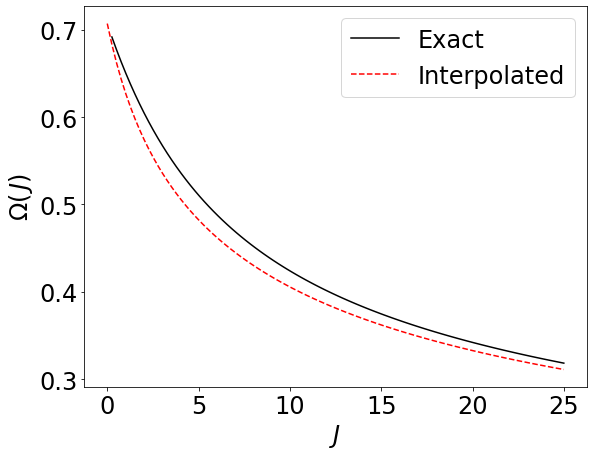

In [57]:
plt.rcParams.update({'font.size':24})

Js_temp = np.linspace(0, 25, 100)
Omega_vect = np.vectorize(Omega)

fig = plt.figure(figsize=(9,7))
plt.plot(Js_temp, Omega_vect(Js_temp), color='black', label="Exact")
plt.plot(Js_temp, Omega_interp(Js_temp), color='red', linestyle='--',label="Interpolated")

plt.xlabel("$J$")
plt.ylabel("$\Omega( \, J )$")
plt.legend()

save_Omega_figure = True
if save_Omega_figure:
    plt.savefig(f'Gaia phase mixing (thesis)/Omega_comparison.png', dpi=300)
    
plt.show()

In [7]:
## define find_z and corresponding four implicit equations

epsabs=1e-6

def find_z(theta, J):
    '''
    Set up an implicit equation whose root (z=z_root) we want to find,
    and return z_root.
    
    '''
    
    z_max = 2 * np.arccosh( np.exp(E_J(J)/2) )
    
    ## should play around with brackets, tolerances
    if (theta < np.pi/2):
        sol = optimize.root_scalar(z_equation_quadrantA, args=(theta, J), \
                                   bracket=[0, z_max*(1-1e-8)]) 
        return sol.root
    elif (theta < np.pi):
        sol = optimize.root_scalar(z_equation_quadrantB, args=(theta, J), \
                                   bracket=[0, z_max*(1-1e-8)]) 
        return sol.root
    elif (theta < 3*np.pi/2):
        sol = optimize.root_scalar(z_equation_quadrantC, args=(theta, J), \
                                   bracket=[-z_max*(1-1e-8), 0]) 
        return sol.root
    elif (theta < 2*np.pi):
        sol = optimize.root_scalar(z_equation_quadrantD, args=(theta, J), \
                                   bracket=[-z_max*(1-1e-8), 0]) 
        return sol.root
    else:
        raise ValueError('theta must be less than 2pi')
    
def z_equation_quadrantA(z, theta, J):
    '''
    The implicit equation for z in Quadrant A: theta in (0, pi/2).
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    #print("z:", z)
    
    # should play around epsabs since we don't want the coordinate conversion to fail 
    # near |z| ~ z_max
    return integrate.quad(one_over_v_z_positive, 0, z, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)

def z_equation_quadrantB(z, theta, J):
    '''
    The implicit equation for z in Quadrant B: theta in (pi/2, pi).
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    
    z_max = 2 * np.arccosh(np.exp(E/2))
    
    # integral for one-fourth of the orbit
    I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E), \
                                     epsabs=epsabs)[0]
    
    return I_quarter_orbit + \
            integrate.quad(one_over_v_z_positive, z, z_max, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)

def z_equation_quadrantC(z, theta, J):
    '''
    The implicit equation for z in Quadrant C: theta in (pi, 3pi/2).
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    
    z_max = 2 * np.arccosh(np.exp(E/2))
    
    # integral for one-fourth of the orbit
    I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E), \
                                     epsabs=epsabs)[0]
    
    return 2*I_quarter_orbit + \
            integrate.quad(one_over_v_z_positive, z, 0, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)


def z_equation_quadrantD(z, theta, J):
    '''
    The implicit equation for z in Quadrant D: theta in (3pi/2, 2pi).
    
    '''
    E = E_J(J) # using step 2, calculate E(J)
    
    z_max = 2 * np.arccosh(np.exp(E/2))
    
    # integral for one-fourth of the orbit
    I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, z_max, args=(E), \
                                     epsabs=epsabs)[0]
    
    return 3*I_quarter_orbit + \
            integrate.quad(one_over_v_z_positive, -z_max, z, args=(E), epsabs=epsabs)[0] \
        - theta/Omega(J)



In [8]:
## doing timing tests + exploring integrating in different directions
J = 20
E = E_J(J) # using step 2, calculate E(J)
    
z_max = 2 * np.arccosh(np.exp(E/2))

epsabs=1e-6

start = time.time()
integrate.quad(one_over_v_z_positive, 0, .5*z_max, args=(E), \
                                     epsabs=epsabs)[0]
# doing 200*1e5 integrals is too long
(time.time()-start)*1e5*200 / 60

74.70448811848958

In [9]:
## find_z tests
# Quadrant A boundary tests
find_z(1e-8, 0.1)
find_z(1e-8, 20)
find_z(np.pi/4, 0.1)
find_z(np.pi/4, 20)
find_z(np.pi/2 * (1-1e-3), 0.1) # roundoff error for 1-1e-4, but still works
find_z(np.pi/2 * (1-1e-3), 20) # roundoff error for 1-1e-4, but still works

print("Quadrant A tests passed")

# Quadrant B boundary tests
find_z(np.pi/2 * (1+1e-4), 0.1) # breaks for 1+1e-5
find_z(np.pi/2 * (1+1e-4), 20) # breaks for 1+1e-5
find_z(3*np.pi/4, 0.1)
find_z(3*np.pi/4, 20)
find_z(np.pi * (1-1e-8), 0.1)
find_z(np.pi * (1-1e-8), 20)

print("Quadrant B tests passed")

# Quadrant C boundary tests
find_z(np.pi * (1+1e-8), 0.1)
find_z(np.pi * (1+1e-8), 20)
find_z(5*np.pi/4, 0.1)
find_z(5*np.pi/4, 20)
find_z(3*np.pi/2 * (1-1e-8), 0.1)
find_z(3*np.pi/2 * (1-1e-8), 20)

print("Quadrant C tests passed")

# Quadrant D boundary tests
find_z(3*np.pi/2 * (1+1e-4), 0.1) # breaks for 1+1e-5
find_z(3*np.pi/2 * (1+1e-4), 20) # breaks for 1+1e-5
find_z(7*np.pi/4, 0.1)
find_z(7*np.pi/4, 20)
find_z(2*np.pi * (1-1e-8), 0.1)
find_z(2*np.pi * (1-1e-8), 20)

print("Quadrant D tests passed")

Quadrant 1 tests passed
Quadrant 2 tests passed
Quadrant 3 tests passed
Quadrant 4 tests passed


# Step 4: Find $v_z$

We'll plug in $E(J)$ and $z$ into $v_z = \pm \sqrt{2(E-\Phi(z))}$.

In [10]:
def convert_AA_to_Cart(theta, J):
    '''
    
    Given theta and J, solve for z and v_z.
    
    '''

    z = find_z(theta, J)
    E = E_J(J)
    
    # casework based on quadrants
    if (theta < 0 or theta > 2*np.pi):
        print("Error: theta not in [0, 2pi]")
        
    if (theta < np.pi/2 or theta > 3*np.pi/2):
        v_z = v_z_positive(z, E)
    else:
        v_z = -v_z_positive(z, E)
    
    return z, v_z

In [11]:
theta_temp = np.pi/2*.99
J_temp = 5
convert_AA_to_Cart(theta_temp, J_temp)

(4.326564979325922, 0.029956649940700915)

# Algorithm 2: Converting from $(z,v_z)$ to $(\theta,J)$

I propose a new algorithm:
1. Sample from (z, v_z)
2. Get E
3. Infer J
4. Do *one* integral that goes from (0 or +-z_max) to z (or vice versa), which lets us solve for $\theta$ directly 

After we get 10,000 points or so, interpolate to get the functions $z(\theta, J)$ and $v_z(\theta, J)$.

In [20]:
def convert_Cart_to_AA(z, v_z):
    '''
    Given z and v_z, solve for theta and J.
    
    theta is calculated by multiplying Omega(J) by some integral over 1/v_z;
    I'll denote this integral as I_z.
    
    '''
    
    E = v_z**2 / 2 + Phi(z)
    J = J_E(E)
    Omega_J = Omega(J)
    I_z = 0 # integral over 1/v_z
    
    ## do casework based on which quadrant we're in
    if (z >= 0):
        
        if (v_z >= 0): # quadrant A
            I_z = integrate.quad(one_over_v_z_positive, 0, z, args=(E))[0]
            
        else: # quadrant B; z>0 and v_z<0
            z_max = 2 * np.arccosh( np.exp(E/2) )
            # integral for one-fourth of the orbit
            I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, \
                                             z_max, args=(E))[0]
            I_z = I_quarter_orbit + \
                integrate.quad(one_over_v_z_positive, z, z_max, args=(E))[0]
            
    else:
        
        if (v_z <= 0): # quadrant C
            z_max = 2 * np.arccosh( np.exp(E/2) )
            # integral for one-fourth of the orbit
            I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, \
                                             z_max, args=(E))[0]
            I_z = 2*I_quarter_orbit + \
                integrate.quad(one_over_v_z_positive, z, 0, args=(E))[0]
            
        else: # quadrant D; z<0 and v_z>0
            z_max = 2 * np.arccosh( np.exp(E/2) )
            # integral for one-fourth of the orbit
            I_quarter_orbit = integrate.quad(one_over_v_z_positive, 0, \
                                             z_max, args=(E))[0]
            
            I_z = 3*I_quarter_orbit + \
                integrate.quad(one_over_v_z_positive, -z_max, z, args=(E))[0]
    
    theta = Omega_J * I_z
    return theta, J

convert_Cart_to_AA_vect = np.vectorize(convert_Cart_to_AA)

In [21]:
convert_Cart_to_AA(0, .06)

(0.0, 0.0025458708012541195)

# check that AA->Cart and Cart->AA conversions are consistent

In [ ]:
theta_temp = np.linspace(0, 2*np.pi*.999, 100)
J_temp = 20

convert_AA_to_Cart_vect = np.vectorize(convert_AA_to_Cart)
zs_temp, vzs_temp = convert_AA_to_Cart_vect(theta_temp, J_temp)

# should print original theta values and J_temp
convert_Cart_to_AA_vect(zs_temp, vzs_temp)

In [31]:
# timing test for both conversion functions
z_temp, vz_temp = -3, 1.2
theta_temp, J_temp = convert_Cart_to_AA(z_temp, vz_temp)

start = time.time()
test_AA_to_Cart_timing = False
if test_AA_to_Cart_timing:
    for i in range(20):
        convert_AA_to_Cart(theta_temp, J_temp)
    delta_t = time.time() - start 
    print("Time for 20 AA->Cart conversions: %2.2f s" % delta_t)

start = time.time()
for i in range(100):
    convert_Cart_to_AA(z_temp, vz_temp)
delta_t = time.time() - start 
print("Time for 100 Cart->AA conversions: %2.2f s" % delta_t)


Time for 100 Cart->AA conversions: 1.59 s


# interpolating AA -> CC conversion

### plot qualitative expectations for $z(\theta,J)$ and $v_z(\theta,J)$

In [ ]:
thetas_temp = np.linspace(0, 2*np.pi*.99, 23)
Js_temp = np.linspace(0.1, 20, 20)
thetas_temp, Js_temp = np.meshgrid(thetas_temp, Js_temp)

def z_interp_expectation(theta, J):
    '''
    Expected approximate form of the interpolated z(theta, J).
    
    '''
    
    return np.sqrt(2*J) * np.sin(theta)

def vz_interp_expectation(theta, J):
    '''
    Expected approximate form of the interpolated v_z(theta, J).
    
    '''
    
    return np.sqrt(2*J) * np.cos(theta)

z_interp_expectation_vect = np.vectorize(z_interp_expectation)
vz_interp_expectation_vect = np.vectorize(vz_interp_expectation)
plt.imshow(vz_interp_expectation_vect(thetas_temp, Js_temp), cmap=cm.coolwarm, 
          extent=[np.min(thetas_temp), np.max(thetas_temp), 
                  np.min(Js_temp), np.max(Js_temp)],
          aspect='auto', origin='lower')
plt.colorbar()
plt.title('qualitative v_z(theta, J)')
plt.show()

In [64]:
# use z_max > 12, v_max > 4.6 since these values correspond to J=25

z_max_for_interp = 15
N_z = 100 # number of z's to sample
zs = np.linspace(-z_max_for_interp, z_max_for_interp, N_z)

vz_max_for_interp = 5
N_vz = 100 # number of v_z's to sample
vzs = np.linspace(-vz_max_for_interp, vz_max_for_interp, N_vz)

N = N_z*N_vz

In [65]:
# compute (theta, J) coords corresponding to a (z, v_z) grid
zs_grid, vzs_grid = np.meshgrid(zs, vzs)
thetas_grid, Js_grid = convert_Cart_to_AA_vect(zs_grid, vzs_grid)

## flatten data to conform to interp function
thetas_grid_flat = thetas_grid.flatten().reshape(N, 1)
Js_grid_flat = Js_grid.flatten().reshape(N, 1)

theta_J_points = np.concatenate((thetas_grid_flat, Js_grid_flat), axis=1)
z_values = zs_grid.flatten()
vz_values = vzs_grid.flatten()

J_max = 25
## include boundary points and their values
theta_J_points_boundary = np.asarray([[0, 0],
                                      [0, 5],
                                      [0, 15],
                                      [0, J_max],
                                      [2*np.pi, 0],
                                      [2*np.pi, 5],
                                      [2*np.pi, 15],
                                      [2*np.pi,J_max],
                                      [np.pi, 0]
                                     ])
z_values_boundary = np.asarray([0, 0, 0, 0,
                                0, 0, 0, 0,
                                0])
vz_values_boundary = np.asarray([0, 2.43596879, 3.812371, 4.6265665, 
                                0, 2.43596879, 3.812371, 4.6265665,
                                0])
theta_J_points = np.concatenate((theta_J_points, theta_J_points_boundary))
z_values = np.concatenate((z_values, z_values_boundary))
vz_values = np.concatenate((vz_values, vz_values_boundary))

Source for interpolating a 2D function: [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html)

Source for saving a function: [link](https://stackoverflow.com/questions/61181567/how-do-i-save-the-outputs-from-jupyter-notebook)

In [ ]:
# points: 2D array with shape (N_z*N_vz, 2)
# values: array with shape (N_z*N_vz)
# xi: 2D array with shape (m, 2); points at which to interpolate data

# empirically, this does better than linear interpolation
grid_z_interp = interp.CloughTocher2DInterpolator(theta_J_points, z_values)
grid_vz_interp = interp.CloughTocher2DInterpolator(theta_J_points, vz_values)

In [ ]:
# save interpolated functions 
save_fns = True
if save_fns:
    with open('z(theta,J)_interp.pkl', 'wb') as file:
        pickle.dump(grid_z_interp, file)

    with open('v_z(theta,J)_interp.pkl', 'wb') as file:
        pickle.dump(grid_vz_interp, file)
    
# load functions
load_fns = True
if load_fns:
    with open('z(theta,J)_interp.pkl', 'rb') as file:
        grid_z_interp = pickle.load(file)
        print("interpolated z loaded")
    with open('v_z(theta,J)_interp.pkl', 'rb') as file:
        grid_vz_interp = pickle.load(file)
        print("interpolated v_z loaded")

In [ ]:
thetas_temp = np.linspace(0, 2*np.pi*.999, 200)
Js_temp = np.linspace(0, 25, 200)
thetas_temp, Js_temp = np.meshgrid(thetas_temp, Js_temp)

plt.imshow(grid_z_interp(thetas_temp, Js_temp), cmap=cm.coolwarm, 
          extent=[np.min(thetas_temp), np.max(thetas_temp), 
                  np.min(Js_temp), np.max(Js_temp)],
          aspect='auto', origin='lower')

plt.colorbar()
plt.xlabel(r"$\theta$")
plt.ylabel("$J$")
plt.title('interpolated z(theta, J)')
plt.show()

In [ ]:
plt.imshow(grid_vz_interp(thetas_temp, Js_temp), cmap=cm.coolwarm, 
          extent=[np.min(thetas_temp), np.max(thetas_temp), 
                  np.min(Js_temp), np.max(Js_temp)],
          aspect='auto', origin='lower')

plt.colorbar()
plt.xlabel(r"$\theta$")
plt.ylabel("$J$")
plt.title('interpolated v_z(theta, J)')
plt.show()

# interpolating CC -> AA conversion

### plot qualitative expectations for $\theta(z, v_z)$ and $J(z, v_z)$

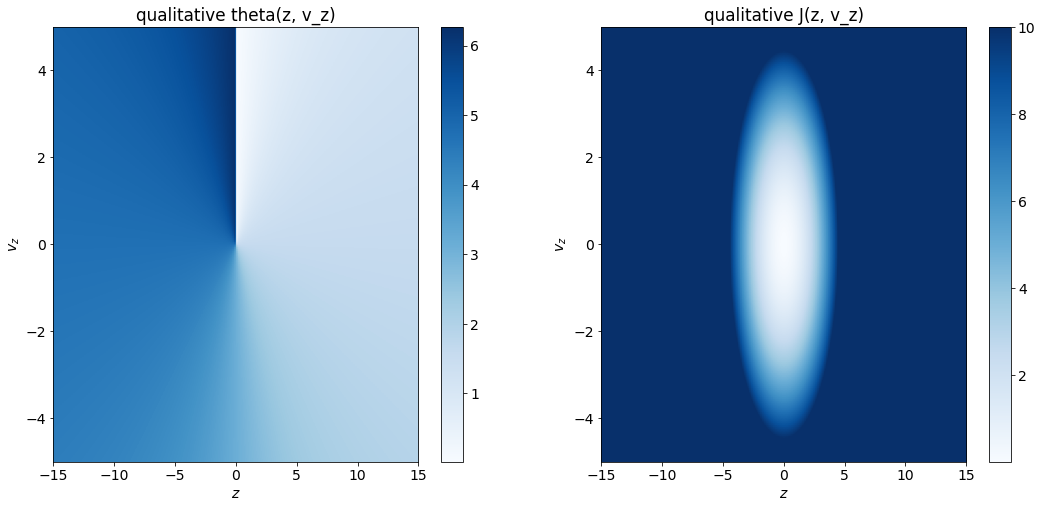

In [43]:
# plot qualitative expectations
zlim = 15
vzlim = 5
zs_temp = np.linspace(-zlim, zlim, 200)
vzs_temp = np.linspace(-vzlim, vzlim, 200)
zs_temp, vzs_temp = np.meshgrid(zs_temp, vzs_temp)

def theta_interp_expectation(z, v_z):
    '''
    Expected approximate form of the interpolated theta(z, v_z).
    
    '''
    
    # the typical range of arctan is [-pi/2, pi/2]
    angle = z / v_z 
    theta = np.arctan(angle)
    
    if (z >= 0):
        if (v_z >= 0): # quadrant A
            return theta
        else: # quadrant B
            return theta + np.pi
    else:
        if (v_z < 0): # quadrant C
            return theta + np.pi
        else: # quadrant D
            return theta + 2*np.pi
    
def J_interp_expectation(z, v_z):
    '''
    Expected approximate form of the interpolated J(z, v_z).
    
    '''
    
    return (z**2 + v_z**2) / 2 

theta_interp_expectation_vect = np.vectorize(theta_interp_expectation)
J_interp_expectation_vect = np.vectorize(J_interp_expectation)

fig, ax = plt.subplots(1, 2, figsize=(18,8))

im1 = ax[0].imshow(theta_interp_expectation_vect(zs_temp, vzs_temp), cmap=cm.Blues, 
          extent=[-zlim, zlim, 
                  -vzlim, vzlim],
          aspect='auto', origin='lower')
fig.colorbar(im1, ax=ax[0])

ax[0].set_xlabel('$z$')
ax[0].set_ylabel('$v_z$')
ax[0].set_title('qualitative theta(z, v_z)')

im2 = ax[1].imshow(J_interp_expectation_vect(zs_temp, vzs_temp), cmap=cm.Blues, 
          extent=[-zlim, zlim, 
                  -vzlim, vzlim],
          aspect='auto', origin='lower', vmax=10)
fig.colorbar(im2, ax=ax[1])

ax[1].set_xlabel('$z$')
ax[1].set_ylabel('$v_z$')
ax[1].set_title('qualitative J(z, v_z)')

plt.show()

## reshape the data used to interpolate AA->CC

In [66]:
z_vz_points = np.hstack((z_values[:,np.newaxis], vz_values[:,np.newaxis])) 
print(z_vz_points.shape) # shape should be (N_z*N_vz, 2)
theta_values = theta_J_points[:, 0]
J_values = theta_J_points[:, 1]

(10009, 2)


In [67]:
grid_theta_interp = interp.CloughTocher2DInterpolator(z_vz_points, theta_values)
grid_J_interp = interp.CloughTocher2DInterpolator(z_vz_points, J_values)

### plot interpolated $\theta(z,v_z)$ and $J(z,v_z)$ functions

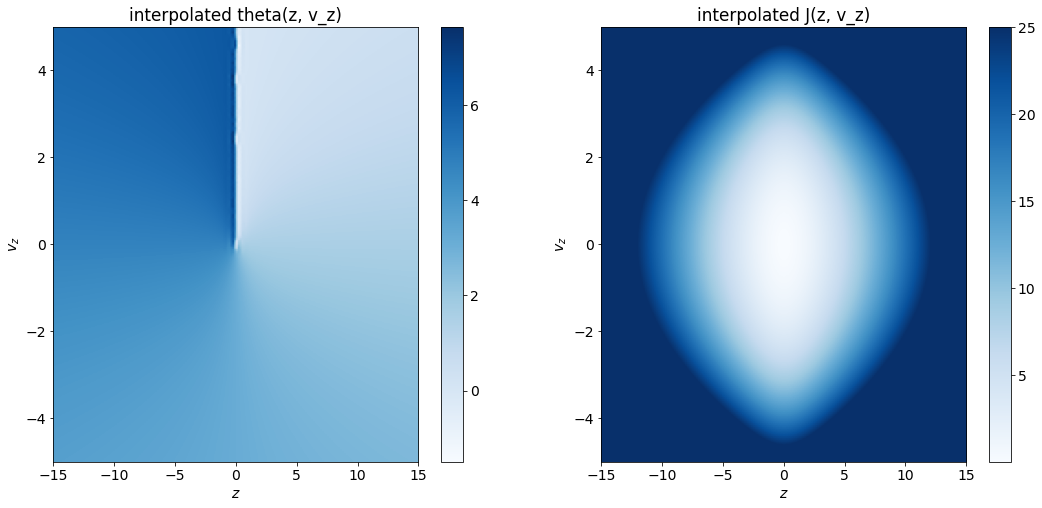

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))

im1 = ax[0].imshow(grid_theta_interp(zs_temp, vzs_temp), cmap=cm.Blues, 
          extent=[-zlim, zlim, 
                  -vzlim, vzlim],
          aspect='auto', origin='lower')
fig.colorbar(im1, ax=ax[0])

ax[0].set_xlabel('$z$')
ax[0].set_ylabel('$v_z$')
ax[0].set_title('interpolated theta(z, v_z)')

im2 = ax[1].imshow(grid_J_interp(zs_temp, vzs_temp), cmap=cm.Blues, 
          extent=[-zlim, zlim, 
                  -vzlim, vzlim],
          aspect='auto', origin='lower', vmax=25)
fig.colorbar(im2, ax=ax[1])

ax[1].set_xlabel('$z$')
ax[1].set_ylabel('$v_z$')
ax[1].set_title('interpolated J(z, v_z)')

plt.show()

In [69]:
# save interpolated functions 
save_fns = True
if save_fns:
    with open('theta(z,v_z)_interp.pkl', 'wb') as file:
        pickle.dump(grid_theta_interp, file)

    with open('J(z,v_z)_interp.pkl', 'wb') as file:
        pickle.dump(grid_J_interp, file)
    
# load functions
load_fns = False
if load_fns:
    with open('theta(z,v_z)_interp.pkl', 'rb') as file:
        grid_theta_interp = pickle.load(file)
        print("interpolated theta loaded")
    with open('J(z,v_z)_interp.pkl', 'rb') as file:
        grid_J_interp = pickle.load(file)
        print("interpolated J loaded")